In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

Data Preprocessing

In [53]:
#表格化resd_csv
train_data=pd.read_csv('./adult/adult.data',header=0,names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'])
test_data=pd.read_csv('./adult/adult.test',header=0,names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'])
#?換成NAN
train_data=train_data.replace(' ?',np.nan)
test_data=test_data.replace(' ?',np.nan)
#找'workclass','occupation','native-country'各自的眾數，NaN替換成眾數
train_data['workclass']=train_data['workclass'].fillna((train_data['workclass'].mode()[0]))
train_data['occupation']=train_data['occupation'].fillna((train_data['occupation'].mode()[0]))
train_data['native-country']=train_data['native-country'].fillna((train_data['native-country'].mode()[0]))
test_data['workclass']=test_data['workclass'].fillna((test_data['workclass'].mode()[0]))
test_data['occupation']=test_data['occupation'].fillna((test_data['occupation'].mode()[0]))
test_data['native-country']=test_data['native-country'].fillna((test_data['native-country'].mode()[0]))
#去除class裡的.跟空白鍵
train_data=train_data.apply(lambda x: x.replace(' ', ''))
test_data=test_data.apply(lambda x: x.replace(' ', ''))
test_data['class'] = test_data['class'].apply(lambda x: x.replace('>50K.','>50K'))
test_data['class'] = test_data['class'].apply(lambda x: x.replace('<=50K.','<=50K'))
labelencoder = LabelEncoder()
labelencoder.fit_transform(test_data['class'])
#刪除意思相近的欄位
train_data=train_data.drop(labels=['education-num'],axis='columns')
test_data=test_data.drop(labels=['education-num'],axis='columns')
#刪除較無意義的欄位
train_data=train_data.drop(labels=['fnlwgt'],axis='columns')
test_data=test_data.drop(labels=['fnlwgt'],axis='columns')
# #刪掉重複的資料
train_data=train_data.drop_duplicates() 
test_data=test_data.drop_duplicates() 
#one hot encoding
train_data=pd.get_dummies(train_data,columns=['workclass','education','marital-status','occupation','relationship','race','sex','native-country','class'],dtype=int)
test_data=pd.get_dummies(test_data,columns=['workclass','education','marital-status','occupation','relationship','race','sex','native-country','class'],dtype=int)
#test_data的feature缺少了'native-country_ Holand-Netherlands'這個欄位，將此欄位補上後，值填0，_並用get_loc找出位置排序好
test_data.insert(loc=76,column='native-country_ Holand-Netherlands',value=0)
#StandardScaler
# scaler = StandardScaler() 
# train_data = scaler.fit_transform(train_data) 
train_data['age'] = (train_data['age']-train_data['age'].mean())/train_data['age'].std()
train_data['capital-gain'] = (train_data['capital-gain']-train_data['capital-gain'].mean())/train_data['capital-gain'].std()
train_data['capital-loss'] = (train_data['capital-loss']-train_data['capital-loss'].mean())/train_data['capital-loss'].std()
train_data['hours-per-week'] = (train_data['hours-per-week']-train_data['hours-per-week'].mean())/train_data['hours-per-week'].std()

test_data['age'] = (test_data['age']-test_data['age'].mean())/test_data['age'].std()
test_data['capital-gain'] = (test_data['capital-gain']-test_data['capital-gain'].mean())/test_data['capital-gain'].std()
test_data['capital-loss'] = (test_data['capital-loss']-test_data['capital-loss'].mean())/test_data['capital-loss'].std()
test_data['hours-per-week'] = (test_data['hours-per-week']-test_data['hours-per-week'].mean())/test_data['hours-per-week'].std()
train_data


,age,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,class_ <=50K,class_ >50K
0,0.783411,-0.154330,-0.229711,-2.169046,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,-0.093577,-0.154330,-0.229711,-0.051149,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,1.002659,-0.154330,-0.229711,-0.051149,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,-0.824401,-0.154330,-0.229711,-0.051149,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.166660,-0.154330,-0.229711,-0.051149,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,1.002659,-0.154330,-0.229711,-0.051149,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
32554,-1.262896,-0.154330,-0.229711,-0.051149,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
32555,-0.897484,-0.154330,-0.229711,-0.208031,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
32557,1.368071,-0.154330,-0.229711,-0.051149,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [54]:
# #MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
# X_scaled = scaler.transform(X)

RandomForestClassifier

In [55]:
#建立模型
train_X, test_X, train_y, test_y = train_data.drop(columns=['hours-per-week'],axis=1), test_data.drop(columns=['hours-per-week'],axis=1), train_data['hours-per-week'], test_data['hours-per-week']
# regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr.fit(train_X, train_y)
# pred_y=regr.predict(test_X)

RandomForestRegressor 績效(MSE，RMSE，MAE、R-Squared)

In [80]:
train_data_score=[]
R2=[]
RMSE=[]
MAPE=[]
for i in range(10,200,10):
    print('i=',i)
    regr = RandomForestRegressor(min_samples_split=35,min_samples_leaf=5,max_depth=i,max_features='sqrt',n_jobs=-1)
    regr.fit(train_X, train_y)
    pred_y=regr.predict(test_X)
    train_data_score.append(regr.score(train_X, train_y))
    R2.append(r2_score(test_y, pred_y))
    RMSE.append(np.sqrt(mean_absolute_error(test_y,pred_y)))
    MAPE.append(mean_absolute_percentage_error(test_y,pred_y))
    print("train_data score:",regr.score(train_X, train_y))
    print("R2:", r2_score(test_y, pred_y))
    print("RMSE:", np.sqrt(mean_absolute_error(test_y,pred_y)))
    print("MAPE:", mean_absolute_percentage_error(test_y,pred_y))
    print('------------------------------------------------------')




i= 10
train_data score: 0.24040513351941084
R2: 0.2326326166771281
RMSE: 0.769283327510507
MAPE: 3.270914979204495
------------------------------------------------------
i= 20
train_data score: 0.29318874887610324
R2: 0.26168978365377893
RMSE: 0.7641985569708454
MAPE: 3.5096852033341515
------------------------------------------------------
i= 30
train_data score: 0.29985251781495126
R2: 0.2625010358814678
RMSE: 0.7639178156411466
MAPE: 3.5331793062653643
------------------------------------------------------
i= 40


In [ ]:
plt.plot(train_data_score)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('train_data_score')
plt.show()

plt.plot(R2)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('R2')
plt.show()

plt.plot(RMSE)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('RMSE')
plt.show()

plt.plot(MAPE)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('MAPE')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_y, y=test_y)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], linestyle='--', color='red', linewidth=2, label='Ideal line (y=x)')
plt.title(f'Predicted vs. Actual Values (R-squared: {r2_score(test_y,pred_y):.2f})')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

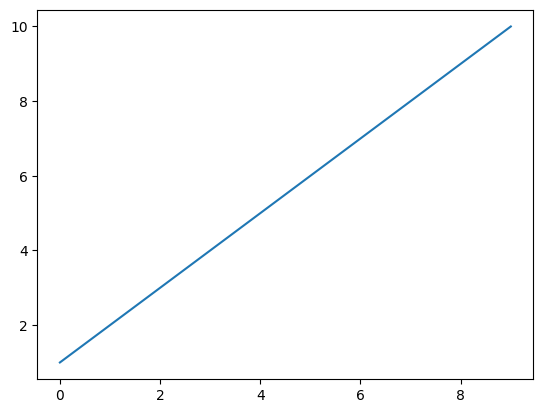

In [ ]:
for i in range(10,40):
    regr = RandomForestRegressor(min_samples_split=60,max_depth=i,max_features='sqrt',n_jobs=-1)
    regr.fit(train_X, train_y)
    pred_y=regr.predict(test_X)
    print("train_data score:",regr.score(train_X, train_y))
    print("R2:", r2_score(test_y, pred_y))
    print("RMSE:", np.sqrt(mean_absolute_error(test_y,pred_y)))
    print("MAPE:", mean_absolute_percentage_error(test_y,pred_y))
    # print('------------------------------------------------------')


In [ ]:
# plotting the y_test vs y_pred
plt.scatter(pred_y,test_y)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()